## Предсказание уровней воды на реке Амур

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
#import shap

from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

In [4]:
# Путь до папки с данными
path_to_data = 'datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [5]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [6]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [7]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [9]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6296, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

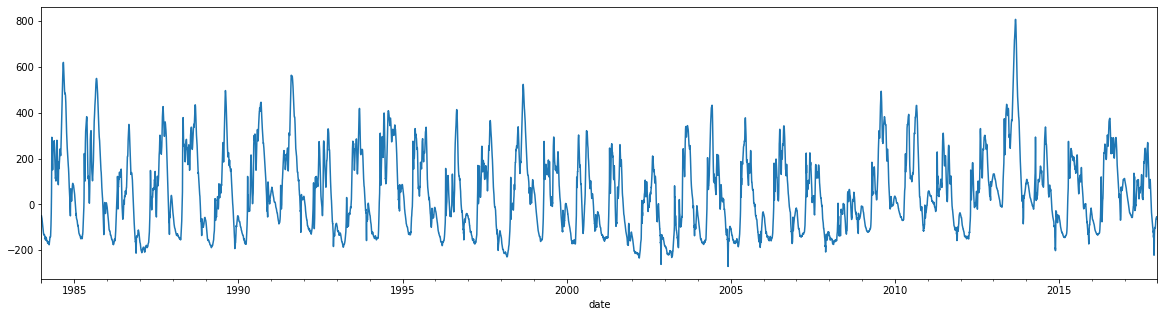

In [10]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [11]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [12]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

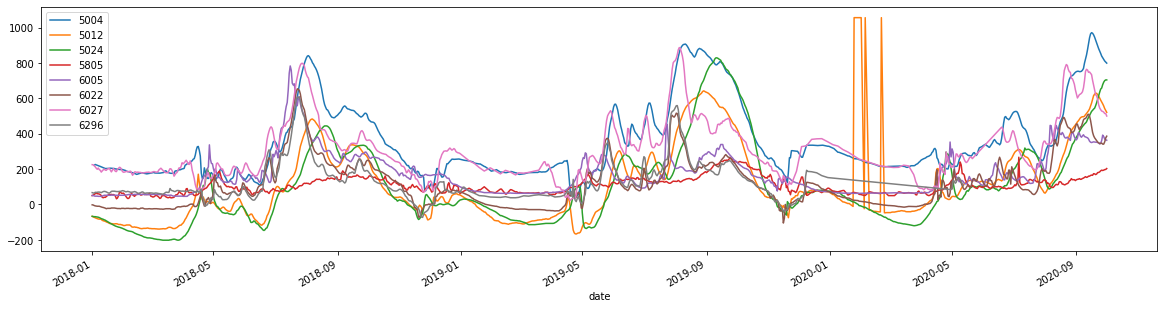

In [13]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [14]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

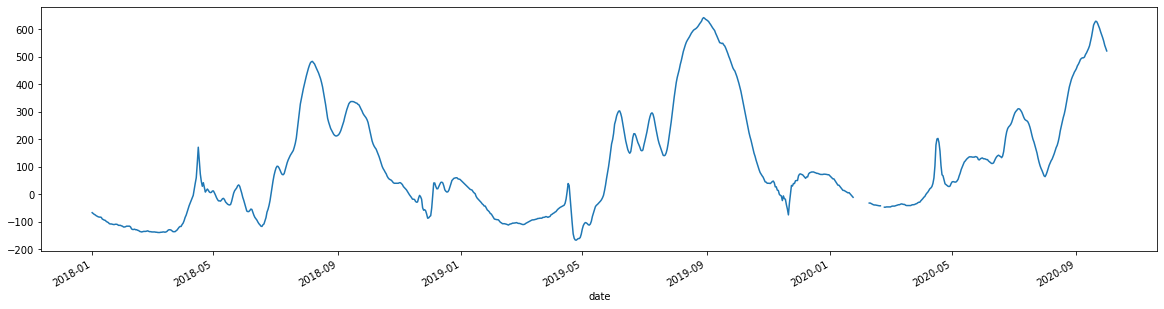

In [15]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [16]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [17]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [18]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,0,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,0,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [19]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [20]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [21]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [22]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.245624
3     -4.826352
6     -2.602431
9     -3.737049
12    -7.484922
15   -10.136460
18   -11.788425
21   -12.990989
Name: temperature_air, dtype: float64

In [23]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [24]:
dmeteo.head()

day_temperature_air  ...  night_temperature_ground
station_id date                             ...                          
5004       1985-01-01              -17.900  ...                   -27.275
           1985-01-02              -16.775  ...                   -29.375
           1985-01-03              -18.975  ...                   -26.900
           1985-01-04              -19.150  ...                   -28.175
           1985-01-05              -21.200  ...                   -28.175

[5 rows x 4 columns]

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [25]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [26]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [27]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [28]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [29]:
daily.shape

(106015, 13)

Создаем "календарные" признаки

In [30]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106015 entries, 0 to 106014
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            106015 non-null  datetime64[ns]
 1   stage_avg                       99037 non-null   float64       
 2   stage_min                       99039 non-null   float64       
 3   stage_max                       105817 non-null  float64       
 4   temp                            66040 non-null   float64       
 5   water_code                      93726 non-null   float64       
 6   station_id                      106015 non-null  int64         
 7   day_temperature_air_15_10       99079 non-null   float64       
 8   night_temperature_air_15_10     99079 non-null   float64       
 9   day_temperature_ground_15_10    98878 non-null   float64       
 10  night_temperature_ground_15_10  98878 non-null   float64

## Восполним пропуски
Для того, чтобы использовать больше данных, используем заполнение пропусков при помощи деревьев решений. Так для каждого признака, в котором, есть пропуски, определим таргет метрику МАЕ или MSE, заполним пропуски оставшихся столбцов медианными значениями и спрогнозируем содержимое пропусков выбранного признака.

In [33]:
def decision_tree_nan_filler(df, column, metric):
  """
  params: df - dataframe
  params: column - column with nans for value prediction
  params: criterion - mae,mse

  returns: y_hat - list of predicted values
  """

  X = df[df[column].notna()].fillna(df.mean()).drop(['date'], axis =1)
  y = X[column].to_list()
  X = X.drop([column], axis = 1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  dtr = DecisionTreeRegressor(random_state=0, criterion = metric, max_depth = 7)
  dtr.fit(X_train, y_train)
  y_hat = dtr.predict(X_test)
  if metric == 'mae':
    print(metric, ' : ', mean_absolute_error(y_test, y_hat))
  elif metric == 'mse':
    print(metric, ' ; ', mean_squared_error(y_test, y_hat))
  y_hat = dtr.predict(df[df[column].isna()].fillna(df.mean()).drop(['date', column], axis =1))
  part_1 = df[df[column].notna()]
  part_2 = df[df[column].isna()]
  part_2[column] = y_hat
  final_df = pd.concat([part_1, part_2]).sort_values(['date'], ascending = True)
  return final_df

In [34]:
 X = daily[daily['temp'].notna()].fillna(daily.mean()).drop(['date'], axis =1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [35]:
X

,stage_avg,stage_min,stage_max,temp,water_code,station_id,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,day,doy
123,338.0,337.0,339.0,6.7,27.00,5004,3.483450,-1.906154,5.336155,-2.913606,705.2906,80.649715,1984,5,3,124
124,352.0,345.0,358.0,6.6,8.27,5004,3.483450,-1.906154,5.336155,-2.913606,705.2906,80.649715,1984,5,4,125
125,385.0,376.0,394.0,7.5,27.00,5004,3.483450,-1.906154,5.336155,-2.913606,705.2906,80.649715,1984,5,5,126
126,430.0,425.0,435.0,6.9,29.00,5004,3.483450,-1.906154,5.336155,-2.913606,705.2906,80.649715,1984,5,6,127
127,471.0,461.0,480.0,6.8,29.00,5004,3.483450,-1.906154,5.336155,-2.913606,705.2906,80.649715,1984,5,7,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105319,60.0,58.0,62.0,0.0,15.00,6296,-3.530000,-7.296667,-2.980000,-7.751667,617.6250,50.700000,2017,11,26,330
105320,65.0,64.0,65.0,0.0,15.00,6296,-4.268333,-8.360000,-3.791667,-8.906667,624.0000,50.400000,2017,11,27,331
105321,69.0,68.0,69.0,0.0,15.00,6296,-5.170000,-9.178333,-4.881667,-9.920000,622.0000,50.100000,2017,11,28,332
105322,72.0,70.0,74.0,0.0,15.00,6296,-6.076667,-10.200000,-5.940000,-11.026667,613.5000,50.100000,2017,11,29,333


In [36]:
daily.columns 

Index(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id', 'day_temperature_air_15_10',
       'night_temperature_air_15_10', 'day_temperature_ground_15_10',
       'night_temperature_ground_15_10', 'humidity_10_10',
       'precipitation_amount_60_10', 'year', 'month', 'day', 'doy'],
      dtype='object')

In [37]:
nan_columns_mae = ['stage_avg', 'stage_min']
nan_columns_mse = ['temp', 'day_temperature_air_15_10', 'night_temperature_air_15_10',
                   'day_temperature_ground_15_10', 'humidity_10_10',
                   'precipitation_amount_60_10','night_temperature_ground_15_10']

In [38]:
for col in nan_columns_mae:
  daily = decision_tree_nan_filler(daily, col, 'mae')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mae  :  2.7132640010770057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mae  :  3.3103123317178245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
for col in nan_columns_mse:
  daily = decision_tree_nan_filler(daily, col, 'mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  3.62264726033613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  0.9842567914624958


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  0.9502511912994799


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  2.061663988504292


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  3885.975055920486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  1172.913303423246


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # Remove the CWD from sys.path while we load stuff.


mse  ;  1.273982030818454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106015 entries, 26619 to 13255
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            106015 non-null  datetime64[ns]
 1   stage_avg                       106015 non-null  float64       
 2   stage_min                       106015 non-null  float64       
 3   stage_max                       105817 non-null  float64       
 4   temp                            106015 non-null  float64       
 5   water_code                      93726 non-null   float64       
 6   station_id                      106015 non-null  int64         
 7   day_temperature_air_15_10       106015 non-null  float64       
 8   night_temperature_air_15_10     106015 non-null  float64       
 9   day_temperature_ground_15_10    106015 non-null  float64       
 10  night_temperature_ground_15_10  106015 non-null  floa

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [41]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [42]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [43]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [44]:
ndays = 20

In [45]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [46]:
daily = daily[daily['target'].notna()]

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predictperiod_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [47]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [48]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [49]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [50]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью 
*train_test_fold(df, f_day, l_day)*. В качестве ошибки на валидационной выборке будем использовать метрику $MAE$

In [75]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='MAE', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    #wmae2_list = []
    for i in range(4):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'MAE':
            eval_metr = lambda x, y: ['MAE', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae_list], 
                        index=['MAE', 'RMSE','WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 5)])
    return res_table

In [52]:
! pip install catboost

     |████████████████████████████████| 66.3MB 42kB/s 


In [53]:
from catboost import CatBoostRegressor

Посмотрим на степень влияния дополнительных признаков на результат работы модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение CatBoost с несколькими параметрами и всеми доп. признакими.

In [54]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_cat = CatBoostRegressor(random_state=33, 
                              #od_wait = 20, 
                              use_best_model = True, #надо отключать при грид сечрче
                              eval_metric = 'MAE',
                              device_config = 'GPU',
                              verbose = False
                              ) 
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_cat.fit(X_train, y_train, eval_set = (X_test, y_test))

In [55]:
! pip install shap

     |████████████████████████████████| 327kB 8.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463897 sha256=6bb7b5668a0656d14c4d4c1af40e585a9054cabb074b9d235e67a948f7872637
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [56]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,past_1_1,past_1_2,past_1_3,past_1_4,past_1_5,past_1_6,past_1_7,past_1_8,past_1_9,past_1_10,past_2_0,past_2_1,past_2_2,past_2_3,past_2_4,past_2_5,past_2_6,past_2_7,past_2_8,past_2_9,past_2_10,past_3_0,past_3_1,past_3_2,past_3_3,past_3_4,past_3_5,past_3_6,past_3_7,past_3_8,past_3_9,past_3_10,past_4_0,past_4_1,past_4_2,past_4_3,past_4_4,past_4_5,past_4_6,past_4_7,past_4_8,past_4_9,past_4_10,past_5_0,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,3.633958,-3.030377,2.907689,-3.68656,573.670489,28.326829,1984.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,3.633958,-3.030377,2.907689,-3.68656,573.670489,28.326829,1984.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,3.633958,-3.030377,2.907689,-3.68656,573.670489,28.326829,1984.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,3.633958,-3.030377,2.907689,-3.68656,573.670489,28.326829,1984.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,3.633958,-3.030377,2.907689,-3.68656,573.670489,28.326829,1984.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,3.633958,-3.030377,2.907689,-3.68656,641.390093,97.011962,2019.0,10.0,300.0,40.0,77.0,247.0,133.0,35.0,309.0,128.0,199.0,40.0,30.0,76.0,-41.0,53.0,212.0,73.0,-42.0,207.0,111.0,132.0,-48.0,-49.0,47.0,56.0,71.0,215.0,64.0,57.0,274.0,105.0,98.0,47.0,47.0,67.0,-13.0,7.0,184.0,39.0,-11.0,200.0,102.0,92.0,-18.0,-14.0,-4.0,-62.0,-7.0,137.0,19.0,-104.0,167.0,77.0,120.0,-63.0,-107.0,-9.0
2019-10-28,3.633958,-3.030377,2.907689,-3.68656,641.390093,97.011962,2019.0,10.0,301.0,40.0,30.0,76.0,195.0,309.0,132.0,136.0,243.0,40.0,188.0,28.0,-48.0,-49.0,47.0,119.0,201.0,68.0,91.0,209.0,-53.0,121.0,-58.0,47.0,47.0,67.0,103.0,265.0,64.0,97.0,212.0,39.0,89.0,37.0,-18.0,-14.0,-4.0,104.0,195.0,46.0,99.0,180.0,-20.0,103.0,-15.0,-63.0,-107.0,-9.0,105.0,163.0,23.0,71.0,131.0,-67.0,99.0,-100.0
2019-10-29,3.633958,-3.030377,2.907689,-3.68656,641.390093,97.011962,2019.0,10.0,302.0,40.0,188.0,28.0,128.0,242.0,119.0,303.0,76.0,125.0,40.0,298.0,-53.0,121.0,-58.0,59.0,197.0,91.0,197.0,41.0,49.0,-57.0,189.0,39.0,89.0,37.0,55.0,214.0,88.0,261.0,61.0,46.0,29.0,261.0,-20.0,103.0,-15.0,40.0,177.0,122.0,186.0,-3.0,21.0,-25.0,179.0,-67.0,99.0,-100.0,23.0,128.0,125.0,159.0,-6.0,17.0,-69.0,159.0
2019-10-30,3.633958,-3.030377,2.907689,-3.68656,641.390093,97.011962,2019.0,10.0,303.0,40.0,298.0,119.0,78.0,181.0,19.0,241.0,121.0,22.0,239.0,82.0,-57.0,189.0,93.0,38.0,123.0,-64.0,197.0,51.0,-71.0,193.0,35.0,29.0,261.0,80.0,43.0,87.0,25.0,214.0,13.0,-3.0,208.0,25.0,-25.0,179.0,111.0,-21.0,93.0,-16.0,156.0,19.0,-21.0,159.0,-20.0,-69.0,159.0,79.0,-5.0,100.0,-105

In [57]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(X_importance)

Построения графика важности дополнительных признаков.

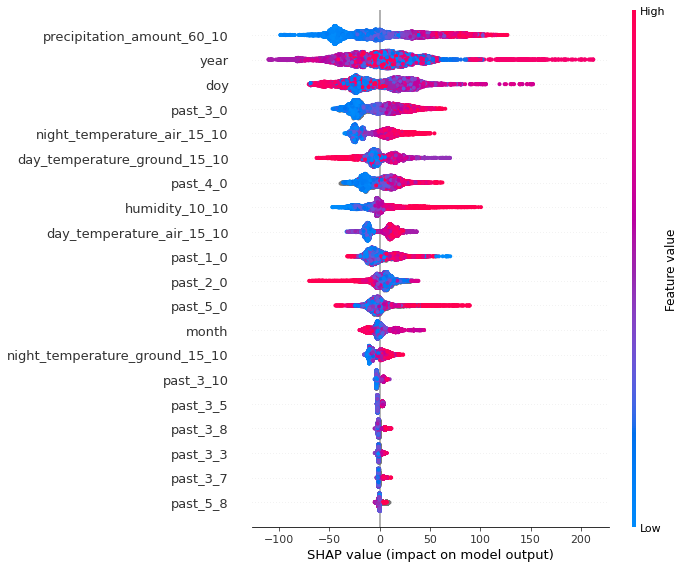

In [58]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [59]:
predict = model_cat.predict(X_test)
true = y_test.values
metrics(true, predict, station_id)

13.354367724699046

###  GridSearch для поиска параметров модели

Простая функция для поиска трех основных параметров модели обучения:

In [60]:
def grid_search(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for l2 in params['l2_leaf_reg']:
                model_cat = CatBoostRegressor(n_estimators=ne,
                                                learning_rate=lr,
                                                l2_leaf_reg = l2,
                                                od_wait = 10, 
                                                use_best_model = False, #надо отключать при грид сечрче
                                                eval_metric = 'MAE',
                                                device_config = 'GPU',
                                                random_state=33)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_cat, df, gen, 'target', features, ndays, 
                                  predict_ndays, station_id, ts, 'MAE', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, l2]))
    return best_params

In [61]:
grid_params = {
    'n_estimators': [30, 70, 110],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg' : [3, 10, 20]
}

In [69]:
grid_params

{'l2_leaf_reg': [3, 10, 20],
 'learning_rate': [0.05, 0.1, 0.2],
 'n_estimators': [30, 70, 110]}

In [ ]:
model_params = {}
for station_id in station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params[station_id] = grid_search(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

In [82]:
import pickle

In [78]:
def model_saver(station_id):
  pkl_filename = 'models/'+str(station_id)+"_model.pkl"
  with open(pkl_filename, 'wb') as file:
      pickle.dump(model_cat, file)

In [92]:
X_test.head()

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,past_1_1,past_1_2,past_1_3,past_1_4,past_1_5,past_1_6,past_1_7,past_1_8,past_1_9,past_1_10,past_2_0,past_2_1,past_2_2,past_2_3,past_2_4,past_2_5,past_2_6,past_2_7,past_2_8,past_2_9,past_2_10,past_3_0,past_3_1,past_3_2,past_3_3,past_3_4,past_3_5,past_3_6,past_3_7,past_3_8,past_3_9,past_3_10,past_4_0,past_4_1,past_4_2,past_4_3,past_4_4,past_4_5,past_4_6,past_4_7,past_4_8,past_4_9,past_4_10,past_5_0,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
2019-11-01,3.633958,-3.030377,2.907689,-3.68656,683.257576,101.750000,2019.0,11.0,305.0,109.0,174.0,271.0,24.0,86.0,42.0,113.0,231.0,114.0,109.0,219.0,101.0,108.0,177.0,-84.0,31.0,-71.0,53.0,181.0,75.0,42.0,173.0,92.0,54.0,237.0,-46.0,30.0,39.0,-3.0,186.0,93.0,-1.0,160.0,103.0,73.0,160.0,-45.0,-15.0,-50.0,11.0,148.0,101.0,13.0,132.0,75.0,99.0,134.0,-118.0,-13.0,-73.0,6.0,125.0,61.0,5.0,118.0
2019-11-02,3.633958,-3.030377,2.907689,-3.68656,683.257576,101.750000,2019.0,11.0,306.0,114.0,109.0,219.0,177.0,260.0,39.0,82.0,114.0,23.0,252.0,19.0,75.0,42.0,173.0,109.0,173.0,-73.0,21.0,65.0,-90.0,168.0,-94.0,93.0,-1.0,160.0,94.0,238.0,45.0,37.0,100.0,-51.0,221.0,-52.0,101.0,13.0,132.0,67.0,156.0,-55.0,-14.0,100.0,-53.0,153.0,-56.0,61.0,5.0,118.0,66.0,125.0,-73.0,-16.0,69.0,-123.0,115.0,-117.0
2019-11-03,3.633958,-3.030377,2.907689,-3.68656,683.257576,101.750000,2019.0,11.0,307.0,114.0,23.0,252.0,19.0,97.0,103.0,77.0,35.0,216.0,178.0,28.0,65.0,-90.0,168.0,-94.0,37.0,55.0,19.0,-76.0,178.0,102.0,-83.0,100.0,-51.0,221.0,-52.0,-10.0,95.0,29.0,42.0,158.0,93.0,27.0,100.0,-53.0,153.0,-56.0,8.0,95.0,-14.0,-60.0,132.0,59.0,-62.0,69.0,-123.0,115.0,-117.0,-3.0,75.0,-24.0,-77.0,118.0,62.0,-89.0
2019-11-04,3.633958,-3.030377,2.907689,-3.68656,683.257576,101.750000,2019.0,11.0,308.0,103.0,77.0,35.0,216.0,178.0,28.0,19.0,77.0,108.0,69.0,162.0,55.0,19.0,-76.0,178.0,102.0,-83.0,-101.0,28.0,67.0,7.0,94.0,95.0,29.0,42.0,158.0,93.0,27.0,-47.0,-21.0,91.0,30.0,97.0,95.0,-14.0,-60.0,132.0,59.0,-62.0,-61.0,-4.0,91.0,-22.0,57.0,75.0,-24.0,-77.0,118.0,62.0,-89.0,-116.0,-15.0,93.0,-30.0,24.0
2019-11-05,3.633958,-3.030377,2.907689,-3.68656,683.257576,97.011962,2019.0,11.0,309.0,108.0,69.0,162.0,215.0,248.0,165.0,24.0,209.0,59.0,17.0,74.0,67.0,7.0,94.0,178.0,161.0,96.0,-88.0,172.0,11.0,-111.0,32.0,91.0,30.0,97.0,177.0,211.0,102.0,17.0,178.0,21.0,-40.0,-43.0,91.0,-22.0,57.0,131.0,148.0,57.0,-67.0,131.0,-35.0,-67.0,-24.0,93.0,-30.0,24.0,115.0,120.0,20.0,-94.0,95.0,-32.0,-125.0,-36.0


6005  MAE:  14.17259568371053


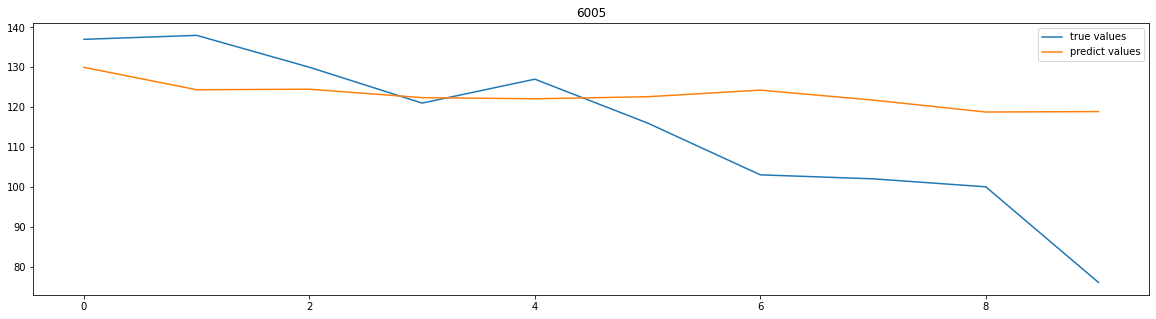

6022  MAE:  11.40592343979833


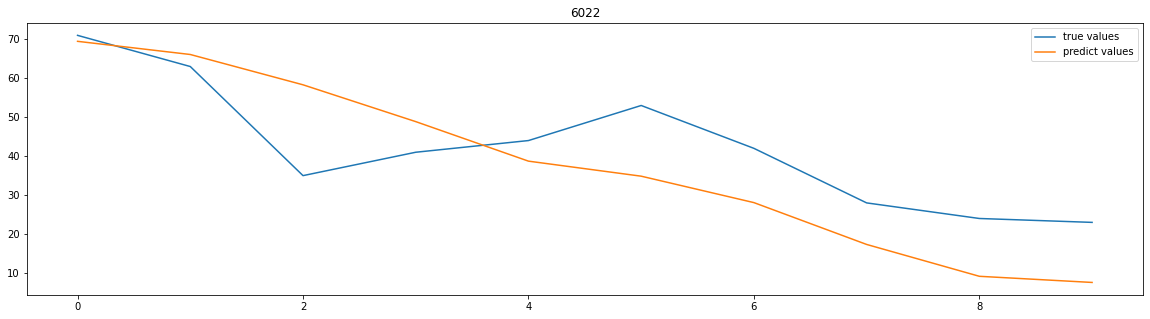

6296  MAE:  18.98819183347589


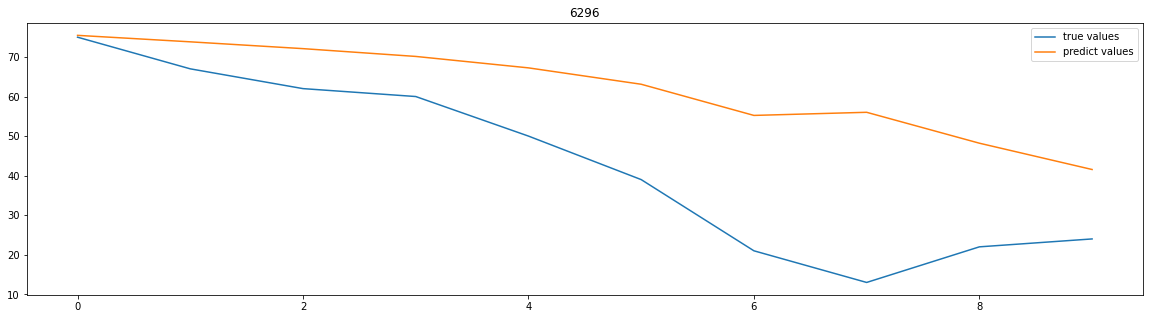

6027  MAE:  10.486607229910692


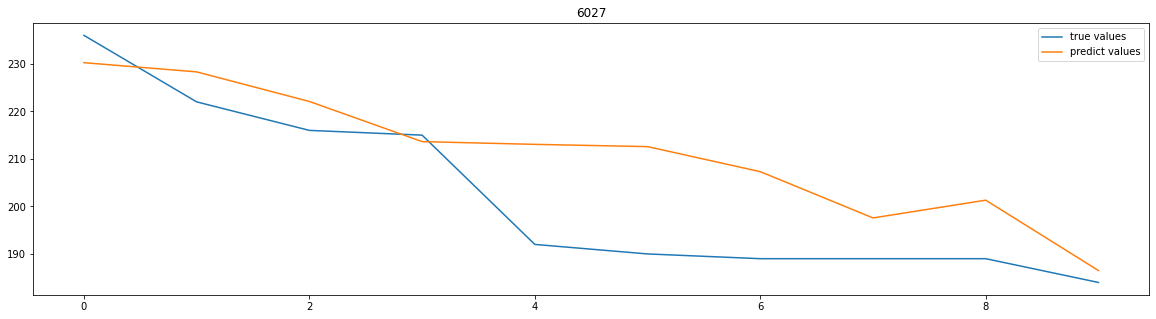

5004  MAE:  20.732146266508515


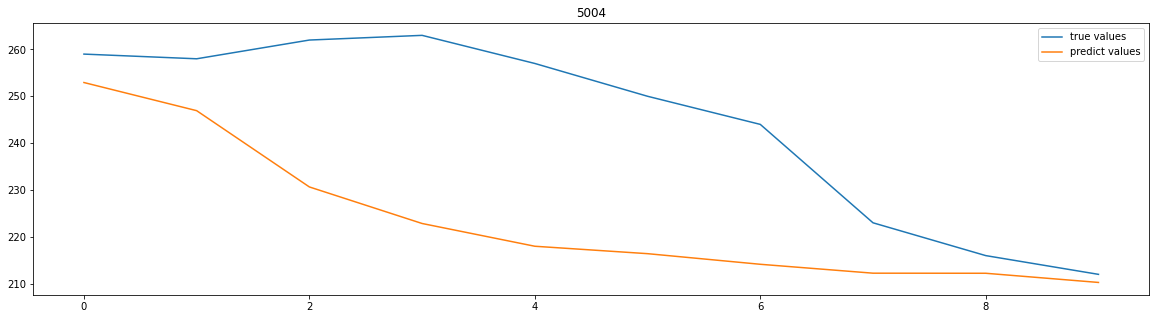

5012  MAE:  27.153571694825104


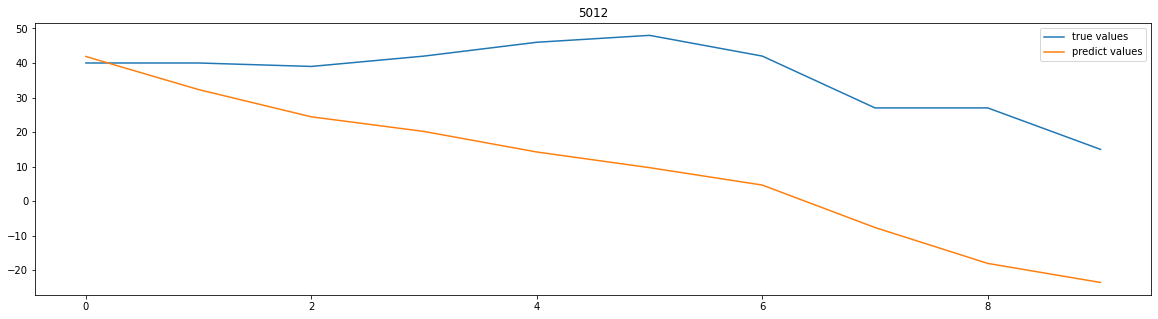

5024  MAE:  37.56819838571405


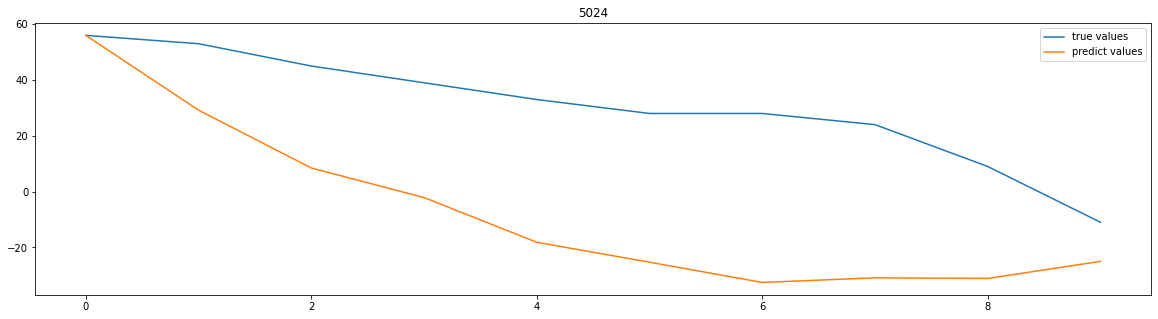

5805  MAE:  19.401423735850653


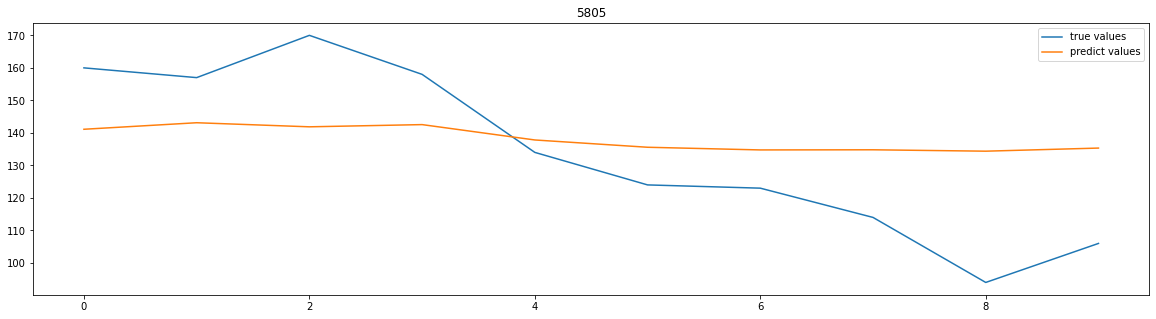

In [91]:
sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
cat_metrics = {}
for key in model_params:
    station_id = int(key)
    params = model_params[key]
    model_cat = CatBoostRegressor(n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              l2_leaf_reg = params['l2_leaf_reg'],
                              od_wait = 10, 
                              eval_metric = 'MAE',
                              device_config = 'GPU',
                              verbose = False,
                              random_state=33)
    sf = daily.loc[int(key)]
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    model_cat.fit(X_train, y_train)
    model_saver(station_id)
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_cat, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    cat_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

Сформируем файл с результатом

In [84]:
sample_submission

,6005,6022,6296,6027,5004,5012,5024,5805
2019-11-01,129.974380,69.467770,75.465226,230.250425,252.933863,41.876807,55.982255,141.114864
2019-11-02,124.356108,66.088340,73.827892,228.313519,246.929019,32.298207,29.166674,143.122921
2019-11-03,124.482274,58.309593,72.106674,222.088077,230.651121,24.418271,8.447624,141.868736
2019-11-04,122.371078,48.860215,70.137136,213.637248,222.852010,20.178974,-2.149785,142.547968
2019-11-05,122.082341,38.716919,67.245786,213.059196,217.996567,14.234862,-18.176294,137.822114
2019-11-06,122.601498,34.856899,63.105551,212.584604,216.413583,9.703992,-25.311934,135.580562
2019-11-07,124.259116,28.073478,55.224506,207.313149,214.148059,4.667577,-32.570972,134.758926
2019-11-08,121.756260,17.336587,56.014707,197.577872,212.249620,-7.625669,-30.917980,134.803429
2019-11-09,118.762738,9.162142,48.203058,201.312895,212.231784,-18.014057,-31.136994,134.374855
2019-11-10,118.870369,7.585118,41.551382,186.504434,210.272912,-23.521067,-25.014579,135.328839


Сохранение результата

In [85]:
sample_submission.to_csv('sample_submission.csv')